## Bibliotecas

In [1]:
import pandas as pd
import yfinance as yf
from datetime import datetime
from bs4 import BeautifulSoup
from datetime import date
import requests
from dotenv import load_dotenv
from langchain_community.document_loaders import TextLoader
from langchain_community.embeddings.openai import OpenAIEmbeddings
from langchain.prompts import PromptTemplate
from langchain_community.vectorstores import FAISS
from langchain_community.chat_models import ChatOpenAI
from langchain import LLMChain
from langchain.agents.agent_types import AgentType
from langchain_experimental.agents.agent_toolkits import create_pandas_dataframe_agent
from datetime import date, timedelta

In [7]:
def baixar_noticias(periodo):
    def baixar_noticias_por_data(data):
        base_url = "https://www.infomoney.com.br/mercados/ibovespa-hoje-bolsa-de-valores-ao-vivo-"
        url = f"{base_url}{data}/"
        response = requests.get(url)

        if response.status_code == 200:
            content = response.content
            soup = BeautifulSoup(content, "html.parser", from_encoding="utf-8")

            # Encontrando todas as notícias e seus respectivos horários
            news_titles = soup.find_all("h2", class_="live-title")
            news_contents = soup.find_all("div", class_="live-content")
            news_times = soup.find_all("span", class_="material-icons live-published-icon")

            news_text = ""
            for title, content, time in zip(news_titles, news_contents, news_times):
                news_text += f"{time.next_sibling.strip()}: {title.get_text(strip=True)}\n\n{content.get_text(strip=True)}\n\n"

            return news_text
        else:
            return None

    noticias = ""
    if periodo == "ultimos_7_dias":
        dias = range(0, 7)
    elif periodo == "semana_anterior":
        dias = range(7, 14)
    else:
        return "Período inválido. Escolha 'ultimos_7_dias' ou 'semana_anterior'."

    for i in dias:
        dia = date.today() - timedelta(days=i)
        data_formatada = dia.strftime("%d%m%Y")
        noticias_dia = baixar_noticias_por_data(data_formatada)
        if noticias_dia:
            noticias += f"Notícias de {dia.strftime('%d/%m/%Y')}:\n\n{noticias_dia}\n\n"

    if noticias:
        return noticias
    else:
        return "Nenhuma notícia disponível no período solicitado."



'Notícias salvas em noticias_ultimos_7_dias.txt.'

In [2]:
def ultimos_dias(periodo):
    def baixar_noticias_por_data(data):
        base_url = "https://www.infomoney.com.br/mercados/ibovespa-hoje-bolsa-de-valores-ao-vivo-"
        url = f"{base_url}{data}/"
        response = requests.get(url)

        if response.status_code == 200:
            content = response.content
            soup = BeautifulSoup(content, "html.parser", from_encoding="utf-8")

            # Encontrando todas as notícias e seus respectivos horários
            news_titles = soup.find_all("h2", class_="live-title")
            news_contents = soup.find_all("div", class_="live-content")
            news_times = soup.find_all(
                "span", class_="material-icons live-published-icon"
            )

            news_text = ""
            for title, content, time in zip(news_titles, news_contents, news_times):
                news_text += f"{time.next_sibling.strip()}: {title.get_text(strip=True)}\n\n{content.get_text(strip=True)}\n\n"

            return news_text
        else:
            return None

    noticias = ""
    if periodo == "ultimos_7_dias":
        dias = range(0, 7)
    elif periodo == "semana_anterior":
        dias = range(7, 14)
    else:
        return "Período inválido. Escolha 'ultimos_7_dias' ou 'semana_anterior'."

    for i in dias:
        dia = date.today() - timedelta(days=i)
        data_formatada = dia.strftime("%d%m%Y")
        noticias_dia = baixar_noticias_por_data(data_formatada)
        if noticias_dia:
            noticias += f"Notícias de {dia.strftime('%d/%m/%Y')}:\n\n{noticias_dia}\n\n"

    if noticias:
        return noticias
    else:
        return "Nenhuma notícia disponível no período solicitado."

ultimos_dias("ultimos_7_dias")

'Notícias de 24/05/2024:\n\n18h06: Encerramos nossa cobertura dos Mercados Ao Vivo\n\nAcessa o Ao Vivo do InfoMoney todos os dias? Então, adicioneeste link aos favoritosdo seu navegador para acompanhar diariamente a cobertura a partir das 8 horas ou acesse oIM Trader, onovo canal do InfoMoney sobre Mercados!\n\n18h06: Na meia hora final, Bitcoin Futuro sobe 2,66%, aos 357.840,00 pontos\n\n\n\n18h04: Na meia hora final, Ibovespa Futuro tem queda de 0,56%, com 124.740 pontos; e Dólar Futuro, mais 0,44%, com 5.166,50 pontos\n\n\n\n18h00: DIs: juros futuros encerram sessão com altas por toda a curva\n\nDia (%)Taxa (%)Variação (pp)NegóciosSemana (%)Maio (%)2024 (%)DI1F250,2910,4150,03030.6940,390,973,84DI1F261,0210,8450,11045.9261,641,8312,85DI1F271,0011,1500,11035.7421,181,2714,71DI1F280,9311,4100,10516.3830,970,8014,85DI1F290,6511,5650,07528.4200,570,2614,85DI1F310,6011,7500,07011.4120,51-0,2514,52DI1F330,6011,8100,0704.3760,43-0,4213,89DI1F350,6011,8100,0701.2890,43-0,5913,78\n\n17h41: I

# Baixar dados yfinance

In [46]:
data = pd.read_csv(r"C:\Users\sensix\Desktop\PESSOAL\PESSOAL\PORTIFOLIO DATA SCIENCE\conselho_camarada\ativos.csv")

def baixar_dados(data):
    # Lista para armazenar os dados das ações
    stock_data = []
   
    # Definir a data de início como 2023-01-01
    start_date = "2024-01-01"
    end_date = datetime.today().strftime('%Y-%m-%d')  # Obter a data de hoje no formato desejado

    # Iterar sobre as linhas do DataFrame
    for index, row in data.iterrows():
        # Obter o nome da empresa e o símbolo do ativo
        nome_empresa = row['Empresa']
        simbolo_ativo = row['Valor']

        # Concatenar o sufixo ".SA" ao símbolo do ativo, se necessário
        if not simbolo_ativo.endswith('.SA'):
            simbolo_ativo += '.SA'

        try:
            # Baixar os dados do ativo
            stock = yf.Ticker(simbolo_ativo)
            stock_history = stock.history(start=start_date, end=end_date, interval="1d")

            # Adicionar uma coluna 'Nome' ao DataFrame dos dados do ativo e definir o valor como o nome da empresa
            stock_history['Nome'] = nome_empresa
            stock_data.append(stock_history)
        except Exception as e:
            print(f"Erro ao baixar dados para o símbolo {simbolo_ativo}: {e}")

    # Concatenar os dados das ações em um único DataFrame
    all_stock_data = pd.concat(stock_data)
    all_stock_data['Date'] = pd.to_datetime(all_stock_data.index)

    # Salvar os dados em um arquivo CSV
    all_stock_data.to_csv('dados_acoes_brasileiras.csv')
    return all_stock_data

baixar_dados(data)

MMMC34F.SA: No price data found, symbol may be delisted (1d 2024-01-01 -> 2024-05-17)
AERI3F.SA: Period '1mo' is invalid, must be one of ['1d', '5d']
AESB3F.SA: Period '1mo' is invalid, must be one of ['1d', '5d']
GRAO3.SA: Period '1mo' is invalid, must be one of ['1d', '5d']
ALSO3.SA: No timezone found, symbol may be delisted
AALR3F.SA: Period '1mo' is invalid, must be one of ['1d', '5d']
ALPA3F.SA: Period '1mo' is invalid, must be one of ['1d', '5d']
ALPA4F.SA: Period '1mo' is invalid, must be one of ['1d', '5d']
APER3F.SA: Period '1mo' is invalid, must be one of ['1d', '5d']
ALUP11F.SA: Period '1mo' is invalid, must be one of ['1d', '5d']
ALUP3F.SA: Period '1mo' is invalid, must be one of ['1d', '5d']
ALUP4F.SA: Period '1mo' is invalid, must be one of ['1d', '5d']
AMZO34F.SA: No price data found, symbol may be delisted (1d 2024-01-01 -> 2024-05-17)
A2MC34.SA: No timezone found, symbol may be delisted
ANIM3F.SA: Period '1mo' is invalid, must be one of ['1d', '5d']
AAPL34F.SA: No pric

KeyboardInterrupt: 

## Web Scraping no Info Money

In [4]:
def baixar_noticias():
    today = date.today().strftime("%d%m%Y")
    
    base_url = "https://www.infomoney.com.br/mercados/ibovespa-hoje-bolsa-de-valores-ao-vivo-"
    url = f"{base_url}{today}/"
    response = requests.get(url)
    
    if response.status_code == 200:
        content = response.content
        soup = BeautifulSoup(content, "html.parser")
        
        # Encontrando todas as notícias e seus respectivos horários
        news_titles = soup.find_all("h2", class_="live-title")
        news_contents = soup.find_all("div", class_="live-content")
        news_times = soup.find_all("span", class_="material-icons live-published-icon")
        
        news_text = ""
        # Iterando sobre as notícias, horários e conteúdos e adicionando ao texto
        for title, content, time in zip(news_titles, news_contents, news_times):
            news_text += f"{time.next_sibling.strip()}: {title.get_text()}\n\n{content.get_text()}\n\n"
        
        file_name = f"noticias_{today}.txt"
        
        # Salvando o texto das notícias em um arquivo de texto
        with open(file_name, "w", encoding="utf-8") as file:
            file.write(news_text)
        
        print(f"As notícias foram salvas no arquivo: {file_name}")
    
    else:
        print("Falha ao acessar a página")

baixar_noticias()

As notícias foram salvas no arquivo: noticias_17052024.txt


# Analises de notícias com IA

In [14]:
# Chave de API do OpenAI
chave = load_dotenv()

# ler noticias
loader = TextLoader(r"C:\Users\sensix\Desktop\PESSOAL\PESSOAL\PORTIFOLIO DATA SCIENCE\conselho_camarada\noticias_17052024.txt")
documents = loader.load()

embeddings = OpenAIEmbeddings()
db = FAISS.from_documents(documents,embeddings)

def retrieve_info(query):
    similar_response = db.similarity_search(query,k=100)
    return similar_response
    

llm = ChatOpenAI(temperature=0, model="gpt-4o")

template = """
Você é um investidor/jornalista que escreve artigos sobre o mercado de investimentos de ações, 
fundos imobiliarios, cripto moedas, Fundos de investimento , Tesouro Direto, Debêntures
ETFs (Exchange Traded Funds), Imóveis e fundos imobiliários (FIIs), CDI , CDB , poupança, taxa de juros, SELIC,
entre outros investimentos, você recebe perguntas de como está o mercado no geral e tentar resumir que 
forma simples e detalhada sobre o que está acontecendo com dados e noticias.

Aqui está perguntas que pessoas vão fazer para você.
{message}

E aqui tenho as principais noticias do dia sobre o mercado de investimentos, organizadas por hora.
{resume}

Para perguntas mais diretas como qual ação teve o melhor ou pior desempenho você deve gerar respostar mais curtas
e objetivas, apenas explicando o por que da alta ou baixa. 
Isso também serve para perguntas de cotações de moedas como o dolar.
Para perguntas de como foi o dia, como foi o desempenho da bolsa você pode fornecer mais detalhes 
mais não passar uma resposta com mais de 7 linhas.

"""
prompt = PromptTemplate(input_variables=["message","resume"],template=template)
chain = LLMChain(llm=llm,prompt=prompt)

def generate_resume(message):
    resume = retrieve_info(message)
    response = chain.run(message=message, resume=resume)
    return response

generate_resume("A multiplan fez alguma captação ?")

'### Pergunta: A Multiplan fez alguma captação?\n\nSim, a Multiplan (MULT3) realizou uma captação de R$ 300 milhões por meio de uma oferta pública de certificados de recebíveis imobiliários (CRIs) da 167ª emissão, em série única, da Virgo Companhia de Securitização. Esses CRIs são lastreados em debêntures simples, não conversíveis em ações, da espécie quirografária, em série única.\n\n### Resumo do Mercado de Investimentos - 17/05/2024\n\n**Bolsa de Valores:**\n- O Ibovespa fechou com uma leve queda de 0,10%, aos 128.150,71 pontos. O índice oscilou entre uma máxima de 128.463,70 e uma mínima de 127.696,11, com um volume financeiro de R$ 24,20 bilhões.\n- As ações da 3R Petroleum (RRRP3) lideraram as altas do dia, subindo 7,14%, enquanto as ações da Gerdau (GGBR4) tiveram a maior queda, de 2,54%.\n\n**Dólar e Juros:**\n- O dólar comercial terminou o dia com uma queda de 0,55%, cotado a R$ 5,102 na venda.\n- Os juros futuros encerraram a sessão com altas em toda a curva, refletindo a cau

## Analises de dataframe com IA

In [8]:
acoes = pd.read_csv(r"C:\Users\sensix\Desktop\PESSOAL\PESSOAL\PORTIFOLIO DATA SCIENCE\conselho_camarada\dados_acoes_brasileiras.csv")
acoes["Date"] = pd.to_datetime(acoes['Date'].str[:10], format='%Y/%m/%d')


Date             datetime64[ns]
Open                    float64
High                    float64
Low                     float64
Close                   float64
Adj Close               float64
Volume                  float64
Nome                     object
Dividends               float64
Stock Splits            float64
Capital Gains           float64
dtype: object



> Entering new AgentExecutor chain...

Invoking: `functions` with `{'query': "import matplotlib.pyplot as plt\nimport pandas as pd\n\ndf['Date'] = pd.to_datetime(df['Date'])\ndf_sorted = df.nlargest(10, 'Open')\n\nplt.figure(figsize=(12, 6))\nfor name, group in df_sorted.groupby('Nome'):\n    plt.bar(group['Date'], group['Open'], label=name)\n\nplt.xlabel('Date')\nplt.ylabel('Open Value')\nplt.title('Top 10 Highest Open Values Categorized by Nome')\nplt.legend()\nplt.xticks(rotation=45)\nplt.tight_layout()\nplt.show()"}`


functions is not a valid tool, try one of [python_repl_ast].
Invoking: `functions` with `{'query': "import matplotlib.pyplot as plt\nimport pandas as pd\n\ndf['Date'] = pd.to_datetime(df['Date'])\ndf_sorted = df.nlargest(10, 'Open')\n\nplt.figure(figsize=(12, 6))\nfor name, group in df_sorted.groupby('Nome'):\n    plt.bar(group['Date'], group['Open'], label=name)\n\nplt.xlabel('Date')\nplt.ylabel('Open Value')\nplt.title('Top 10 Highest Open Values Categorized by N

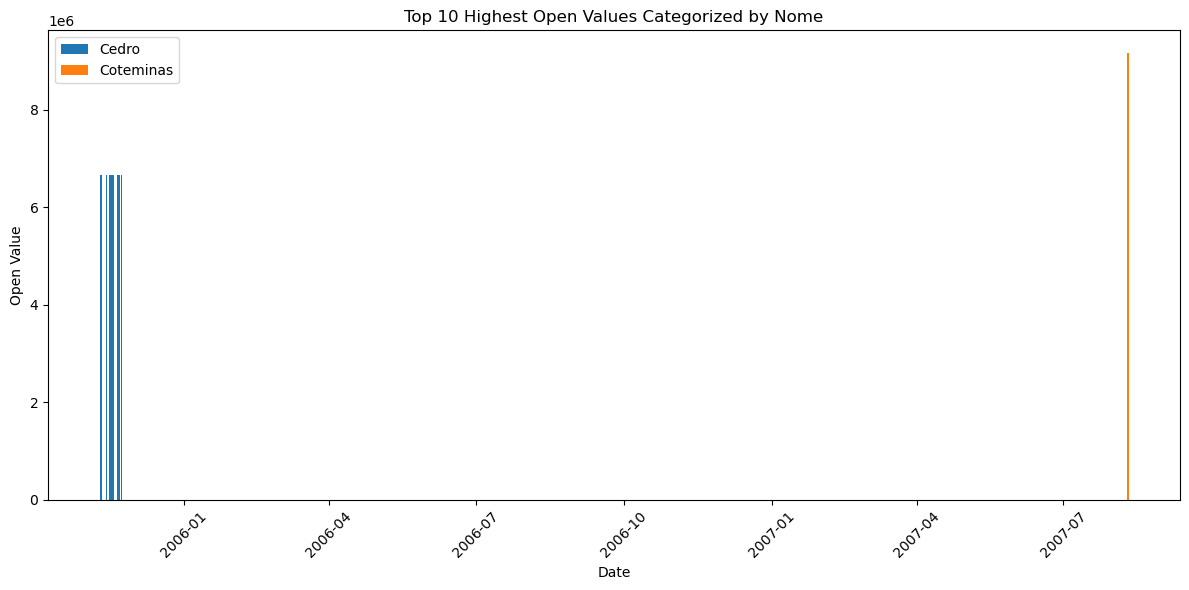

Here is the bar chart displaying the top 10 highest Open values categorized by Nome.

> Finished chain.


{'input': 'show me a bar chart with the 10 highest Open values \u200b\u200bcategorizing by Nome',
 'output': 'Here is the bar chart displaying the top 10 highest Open values categorized by Nome.'}

In [10]:
primo_rico = create_pandas_dataframe_agent(
    ChatOpenAI(temperature=0, model="gpt-4o"),
    acoes,
    verbose=True,
    agent_type=AgentType.OPENAI_FUNCTIONS,
)

primo_rico.invoke("show me a bar chart with the 10 highest Open values ​​categorizing by Nome")